### 1. Problem Definition
Where and when is best to late a restaurant so as to maximize revenue

### 2. Data
https://www.kaggle.com/competitions/restaurant-revenue-prediction/data

### 3. Evaluation
Root mean squared error is the preferred metric

### 4. Features
* `Id` : Restaurant id. 
* `Open Date` : opening date for a restaurant
* `City` : City that the restaurant is in. Note that there are unicode in the names. 
* `City Group`: Type of the city. Big cities, or Other. 
* `Type`: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
* `P1`, `P2` - `P37`: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
* `Revenue`: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

In [1]:
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import opendatasets as od

In [3]:
od.download('https://www.kaggle.com/competitions/restaurant-revenue-prediction/data')

Skipping, found downloaded files in ".\restaurant-revenue-prediction" (use force=True to force download)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import zipfile
from zipfile import ZipFile

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
# Unzip files
with zipfile.ZipFile('restaurant-revenue-prediction/train.csv.zip', 'r') as my_zip:
    my_zip.extractall()

with zipfile.ZipFile('restaurant-revenue-prediction/test.csv.zip', 'r') as my_zip:
    my_zip.extractall()

In [6]:
df_rest = pd.read_csv('train.csv', parse_dates=['Open Date'])
df_rest

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2008-06-25,Trabzon,Other,FC,2,3.0,3.0,5.0,4,...,3.0,0,0,0,0,0,0,0,0,5787594.0
133,133,2006-10-12,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,9262754.0
134,134,2006-07-08,Kayseri,Other,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,2544857.0
135,135,2010-10-29,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,7217634.0


In [7]:
df_rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          137 non-null    int64         
 1   Open Date   137 non-null    datetime64[ns]
 2   City        137 non-null    object        
 3   City Group  137 non-null    object        
 4   Type        137 non-null    object        
 5   P1          137 non-null    int64         
 6   P2          137 non-null    float64       
 7   P3          137 non-null    float64       
 8   P4          137 non-null    float64       
 9   P5          137 non-null    int64         
 10  P6          137 non-null    int64         
 11  P7          137 non-null    int64         
 12  P8          137 non-null    int64         
 13  P9          137 non-null    int64         
 14  P10         137 non-null    int64         
 15  P11         137 non-null    int64         
 16  P12         137 non-null  

In [8]:
df_rest.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


In [9]:
# Renaming columns for ease of coding
df_rest.columns = df_rest.columns.str.replace('City Group', 'City_Group')
df_rest.columns = df_rest.columns.str.replace('Open Date', 'Open_Date')
df_rest

,Id,Open_Date,City,City_Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2008-06-25,Trabzon,Other,FC,2,3.0,3.0,5.0,4,...,3.0,0,0,0,0,0,0,0,0,5787594.0
133,133,2006-10-12,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,9262754.0
134,134,2006-07-08,Kayseri,Other,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,2544857.0
135,135,2010-10-29,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,7217634.0


In [10]:
# Convert object columns to categorical
df_rest.City = pd.Categorical(df_rest.City)
df_rest.City_Group = pd.Categorical(df_rest.City_Group)
df_rest.Type = pd.Categorical(df_rest.Type)

In [11]:
# Add categorical codes column
df_rest['City_codes'] = df_rest.City.cat.codes+1
df_rest['City_Group_codes'] = df_rest.City_Group.cat.codes+1
df_rest['Type_codes'] = df_rest.Type.cat.codes+1

In [12]:
df_rest

,Id,Open_Date,City,City_Group,Type,P1,P2,P3,P4,P5,...,P32,P33,P34,P35,P36,P37,revenue,City_codes,City_Group_codes,Type_codes
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,4,5,5,4,3,4,5653753.0,32,1,3
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,0,0,0,0,0,0,6923131.0,4,1,2
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,0,0,0,0,0,0,2055379.0,11,2,3
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,10,6,18,12,12,6,2675511.0,29,2,3
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3,2,3,4,3,3,4316715.0,15,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2008-06-25,Trabzon,Other,FC,2,3.0,3.0,5.0,4,...,0,0,0,0,0,0,5787594.0,30,2,2
133,133,2006-10-12,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,...,0,0,0,0,0,0,9262754.0,33,1,2
134,134,2006-07-08,Kayseri,Other,FC,3,4.0,4.0,4.0,2,...,0,0,0,0,0,0,2544857.0,19,2,2
135,135,2010-10-29,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,...,0,0,0,0,0,0,7217634.0,32,1,2


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [14]:
# Listing categorical columns
non_num_columns = df_rest.select_dtypes('category').columns.to_list()
non_num_columns

['City', 'City_Group', 'Type']

In [15]:
# Drop non-numerical columns
def drop_non_num_cols(df):
    non_num_columns = df.select_dtypes('category').columns.to_list()
    df.drop(non_num_columns, axis=1, inplace=True)      

In [16]:
drop_non_num_cols(df_rest)

In [17]:
df_rest

,Id,Open_Date,P1,P2,P3,P4,P5,P6,P7,P8,...,P32,P33,P34,P35,P36,P37,revenue,City_codes,City_Group_codes,Type_codes
0,0,1999-07-17,4,5.0,4.0,4.0,2,2,5,4,...,4,5,5,4,3,4,5653753.0,32,1,3
1,1,2008-02-14,4,5.0,4.0,4.0,1,2,5,5,...,0,0,0,0,0,0,6923131.0,4,1,2
2,2,2013-03-09,2,4.0,2.0,5.0,2,3,5,5,...,0,0,0,0,0,0,2055379.0,11,2,3
3,3,2012-02-02,6,4.5,6.0,6.0,4,4,10,8,...,10,6,18,12,12,6,2675511.0,29,2,3
4,4,2009-05-09,3,4.0,3.0,4.0,2,2,5,5,...,3,2,3,4,3,3,4316715.0,15,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2008-06-25,2,3.0,3.0,5.0,4,2,4,4,...,0,0,0,0,0,0,5787594.0,30,2,2
133,133,2006-10-12,4,5.0,4.0,4.0,2,3,5,4,...,0,0,0,0,0,0,9262754.0,33,1,2
134,134,2006-07-08,3,4.0,4.0,4.0,2,3,5,5,...,0,0,0,0,0,0,2544857.0,19,2,2
135,135,2010-10-29,4,5.0,4.0,5.0,2,2,5,5,...,0,0,0,0,0,0,7217634.0,32,1,2


In [18]:
# Check for correlations
df_rest.corrwith(df_rest['revenue'])

Id                 -0.006277
P1                  0.070217
P2                  0.191518
P3                 -0.024613
P4                  0.035685
P5                 -0.028191
P6                  0.139094
P7                  0.051165
P8                 -0.084215
P9                 -0.050352
P10                -0.073220
P11                 0.084247
P12                -0.062193
P13                -0.105085
P14                 0.006441
P15                 0.000742
P16                -0.037997
P17                 0.067137
P18                -0.034537
P19                 0.027984
P20                 0.014147
P21                 0.097411
P22                 0.083562
P23                 0.045507
P24                 0.014222
P25                 0.036365
P26                -0.007650
P27                -0.013680
P28                 0.155534
P29                -0.114846
P30                -0.066203
P31                -0.040418
P32                -0.065857
P33                -0.032426
P34           

In [19]:
# Split date column
def split_date(df):
    df['day'] = df['Open_Date'].dt.day
    df['month'] = df['Open_Date'].dt.month
    df['year'] = df['Open_Date'].dt.year

In [20]:
split_date(df_rest)
df_rest

,Id,Open_Date,P1,P2,P3,P4,P5,P6,P7,P8,...,P35,P36,P37,revenue,City_codes,City_Group_codes,Type_codes,day,month,year
0,0,1999-07-17,4,5.0,4.0,4.0,2,2,5,4,...,4,3,4,5653753.0,32,1,3,17,7,1999
1,1,2008-02-14,4,5.0,4.0,4.0,1,2,5,5,...,0,0,0,6923131.0,4,1,2,14,2,2008
2,2,2013-03-09,2,4.0,2.0,5.0,2,3,5,5,...,0,0,0,2055379.0,11,2,3,9,3,2013
3,3,2012-02-02,6,4.5,6.0,6.0,4,4,10,8,...,12,12,6,2675511.0,29,2,3,2,2,2012
4,4,2009-05-09,3,4.0,3.0,4.0,2,2,5,5,...,4,3,3,4316715.0,15,2,3,9,5,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2008-06-25,2,3.0,3.0,5.0,4,2,4,4,...,0,0,0,5787594.0,30,2,2,25,6,2008
133,133,2006-10-12,4,5.0,4.0,4.0,2,3,5,4,...,0,0,0,9262754.0,33,1,2,12,10,2006
134,134,2006-07-08,3,4.0,4.0,4.0,2,3,5,5,...,0,0,0,2544857.0,19,2,2,8,7,2006
135,135,2010-10-29,4,5.0,4.0,5.0,2,2,5,5,...,0,0,0,7217634.0,32,1,2,29,10,2010


In [21]:
# Drop the date column as it is not compatible with our proposed model
df_rest = df_rest.drop('Open_Date', axis=1).copy()
df_rest

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P35,P36,P37,revenue,City_codes,City_Group_codes,Type_codes,day,month,year
0,0,4,5.0,4.0,4.0,2,2,5,4,5,...,4,3,4,5653753.0,32,1,3,17,7,1999
1,1,4,5.0,4.0,4.0,1,2,5,5,5,...,0,0,0,6923131.0,4,1,2,14,2,2008
2,2,2,4.0,2.0,5.0,2,3,5,5,5,...,0,0,0,2055379.0,11,2,3,9,3,2013
3,3,6,4.5,6.0,6.0,4,4,10,8,10,...,12,12,6,2675511.0,29,2,3,2,2,2012
4,4,3,4.0,3.0,4.0,2,2,5,5,5,...,4,3,3,4316715.0,15,2,3,9,5,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2,3.0,3.0,5.0,4,2,4,4,4,...,0,0,0,5787594.0,30,2,2,25,6,2008
133,133,4,5.0,4.0,4.0,2,3,5,4,4,...,0,0,0,9262754.0,33,1,2,12,10,2006
134,134,3,4.0,4.0,4.0,2,3,5,5,5,...,0,0,0,2544857.0,19,2,2,8,7,2006
135,135,4,5.0,4.0,5.0,2,2,5,5,5,...,0,0,0,7217634.0,32,1,2,29,10,2010


In [22]:
# Split into X & y
X = df_rest.drop('revenue', axis=1)
y = df_rest['revenue']

In [23]:
# Split data 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
 X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 10 to 102
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                109 non-null    int64  
 1   P1                109 non-null    int64  
 2   P2                109 non-null    float64
 3   P3                109 non-null    float64
 4   P4                109 non-null    float64
 5   P5                109 non-null    int64  
 6   P6                109 non-null    int64  
 7   P7                109 non-null    int64  
 8   P8                109 non-null    int64  
 9   P9                109 non-null    int64  
 10  P10               109 non-null    int64  
 11  P11               109 non-null    int64  
 12  P12               109 non-null    int64  
 13  P13               109 non-null    float64
 14  P14               109 non-null    int64  
 15  P15               109 non-null    int64  
 16  P16               109 non-null    int64  
 

In [25]:
from xgboost import XGBRFRegressor

In [26]:
# Instantiate model
model = XGBRFRegressor(random_state=42)

In [27]:
# Fit model
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=12,
               num_parallel_tree=100, objective='reg:squarederror',
               predictor='auto', random_state=42, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [28]:
model.score(X_train, y_train)

0.8601638648310781

In [29]:
val_preds = model.predict(X_val)
val_preds

array([3081196.2, 4726981. , 2366525.5, 3773338.2, 3849064.2, 3639909.2,
       5307346.5, 5249413. , 5881276.5, 5103154. , 4468494.5, 4015487.2,
       3496432. , 5914094. , 4533603. , 5165390.5, 4390720.5, 3783470.2,
       3930160.8, 3473949. , 3840012. , 4353241.5, 3570066.2, 3968023.5,
       5288087.5, 4697615. , 5150794.5, 4355696. ], dtype=float32)

In [30]:
val_mse = mean_squared_error(y_val, val_preds)
val_mse

10620690733374.447

In [31]:
val_rmse = np.sqrt(val_mse)
val_rmse

3258940.1242389292

In [32]:
y_val

105     2792031.0
104     4467728.0
12      1734634.0
26      2267425.0
123     4263629.0
66      1882131.0
64      2551252.0
115     4882985.0
133     9262754.0
85      7495092.0
84      4250553.0
45      3752885.0
69      3452382.0
67      4052733.0
31      2058644.0
42      4952255.0
27      5435276.0
19      2021934.0
132     5787594.0
56      2390534.0
125     4780607.0
4       4316715.0
109     4219263.0
36      3028267.0
89      2364478.0
100     9652350.0
16     19696939.0
18      5337526.0
Name: revenue, dtype: float64

In [33]:
df_test = pd.read_csv('test.csv', parse_dates=['Open Date'])
df_test

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,2011-01-22,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,2011-03-18,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,2013-10-30,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,2013-05-06,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,2013-07-31,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2000-01-05,Antalya,Other,FC,5,5.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
99996,99996,2011-07-18,Niğde,Other,IL,1,2.0,4.0,3.0,1,...,1.0,3.0,5,0,0,0,4,0,0,0
99997,99997,2012-12-29,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,...,4.0,1.0,5,5,3,2,4,4,4,2
99998,99998,2013-10-12,İstanbul,Big Cities,FC,12,7.5,6.0,6.0,4,...,7.5,5.0,0,0,0,4,0,0,0,0


In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Id          100000 non-null  int64         
 1   Open Date   100000 non-null  datetime64[ns]
 2   City        100000 non-null  object        
 3   City Group  100000 non-null  object        
 4   Type        100000 non-null  object        
 5   P1          100000 non-null  int64         
 6   P2          100000 non-null  float64       
 7   P3          100000 non-null  float64       
 8   P4          100000 non-null  float64       
 9   P5          100000 non-null  int64         
 10  P6          100000 non-null  int64         
 11  P7          100000 non-null  int64         
 12  P8          100000 non-null  int64         
 13  P9          100000 non-null  int64         
 14  P10         100000 non-null  int64         
 15  P11         100000 non-null  int64         
 16  P12

In [35]:
df_test.columns = df_test.columns.str.replace('City Group', 'City_Group')
df_test.columns = df_test.columns.str.replace('Open Date', 'Open_Date')
df_test

,Id,Open_Date,City,City_Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,2011-01-22,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,2011-03-18,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,2013-10-30,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,2013-05-06,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,2013-07-31,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2000-01-05,Antalya,Other,FC,5,5.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
99996,99996,2011-07-18,Niğde,Other,IL,1,2.0,4.0,3.0,1,...,1.0,3.0,5,0,0,0,4,0,0,0
99997,99997,2012-12-29,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,...,4.0,1.0,5,5,3,2,4,4,4,2
99998,99998,2013-10-12,İstanbul,Big Cities,FC,12,7.5,6.0,6.0,4,...,7.5,5.0,0,0,0,4,0,0,0,0


In [36]:
# Convert object columns to categorical
df_test.City = pd.Categorical(df_test.City)
df_test.City_Group = pd.Categorical(df_test.City_Group)
df_test.Type = pd.Categorical(df_test.Type)

In [37]:
# Add categorical codes column
df_test['City_codes'] = df_test.City.cat.codes+1
df_test['City_Group_codes'] = df_test.City_Group.cat.codes+1
df_test['Type_codes'] = df_test.Type.cat.codes+1

In [38]:
df_test

,Id,Open_Date,City,City_Group,Type,P1,P2,P3,P4,P5,...,P31,P32,P33,P34,P35,P36,P37,City_codes,City_Group_codes,Type_codes
0,0,2011-01-22,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,0,0,0,0,0,0,0,39,2,2
1,1,2011-03-18,Konya,Other,IL,3,4.0,4.0,4.0,2,...,0,0,0,0,0,0,0,28,2,3
2,2,2013-10-30,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,0,0,0,0,0,0,0,4,1,2
3,3,2013-05-06,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,4,0,0,0,0,0,0,27,2,3
4,4,2013-07-31,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,0,0,0,0,0,0,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2000-01-05,Antalya,Other,FC,5,5.0,4.0,4.0,2,...,0,0,0,0,0,0,0,5,2,2
99996,99996,2011-07-18,Niğde,Other,IL,1,2.0,4.0,3.0,1,...,0,0,0,4,0,0,0,39,2,3
99997,99997,2012-12-29,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,...,5,3,2,4,4,4,2,55,1,3
99998,99998,2013-10-12,İstanbul,Big Cities,FC,12,7.5,6.0,6.0,4,...,0,0,4,0,0,0,0,55,1,2


In [39]:
# Drop non-numerical columns
drop_non_num_cols(df_test)

In [40]:
df_test

,Id,Open_Date,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,City_codes,City_Group_codes,Type_codes
0,0,2011-01-22,1,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,0,0,0,39,2,2
1,1,2011-03-18,3,4.0,4.0,4.0,2,2,5,3,...,0,0,0,0,0,0,0,28,2,3
2,2,2013-10-30,3,4.0,4.0,4.0,2,2,5,4,...,0,0,0,0,0,0,0,4,1,2
3,3,2013-05-06,2,4.0,4.0,4.0,2,3,5,4,...,4,0,0,0,0,0,0,27,2,3
4,4,2013-07-31,2,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,0,0,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2000-01-05,5,5.0,4.0,4.0,2,2,5,5,...,0,0,0,0,0,0,0,5,2,2
99996,99996,2011-07-18,1,2.0,4.0,3.0,1,1,1,5,...,0,0,0,4,0,0,0,39,2,3
99997,99997,2012-12-29,4,5.0,4.0,4.0,1,2,5,3,...,5,3,2,4,4,4,2,55,1,3
99998,99998,2013-10-12,12,7.5,6.0,6.0,4,4,10,10,...,0,0,4,0,0,0,0,55,1,2


In [41]:
split_date(df_test)

In [42]:
df_test

,Id,Open_Date,P1,P2,P3,P4,P5,P6,P7,P8,...,P34,P35,P36,P37,City_codes,City_Group_codes,Type_codes,day,month,year
0,0,2011-01-22,1,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,39,2,2,22,1,2011
1,1,2011-03-18,3,4.0,4.0,4.0,2,2,5,3,...,0,0,0,0,28,2,3,18,3,2011
2,2,2013-10-30,3,4.0,4.0,4.0,2,2,5,4,...,0,0,0,0,4,1,2,30,10,2013
3,3,2013-05-06,2,4.0,4.0,4.0,2,3,5,4,...,0,0,0,0,27,2,3,6,5,2013
4,4,2013-07-31,2,4.0,4.0,4.0,1,2,5,4,...,0,0,0,0,2,2,2,31,7,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2000-01-05,5,5.0,4.0,4.0,2,2,5,5,...,0,0,0,0,5,2,2,5,1,2000
99996,99996,2011-07-18,1,2.0,4.0,3.0,1,1,1,5,...,4,0,0,0,39,2,3,18,7,2011
99997,99997,2012-12-29,4,5.0,4.0,4.0,1,2,5,3,...,4,4,4,2,55,1,3,29,12,2012
99998,99998,2013-10-12,12,7.5,6.0,6.0,4,4,10,10,...,0,0,0,0,55,1,2,12,10,2013


In [43]:
df_test = df_test.drop('Open_Date', axis=1).copy()
df_test

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P34,P35,P36,P37,City_codes,City_Group_codes,Type_codes,day,month,year
0,0,1,4.0,4.0,4.0,1,2,5,4,5,...,0,0,0,0,39,2,2,22,1,2011
1,1,3,4.0,4.0,4.0,2,2,5,3,4,...,0,0,0,0,28,2,3,18,3,2011
2,2,3,4.0,4.0,4.0,2,2,5,4,4,...,0,0,0,0,4,1,2,30,10,2013
3,3,2,4.0,4.0,4.0,2,3,5,4,5,...,0,0,0,0,27,2,3,6,5,2013
4,4,2,4.0,4.0,4.0,1,2,5,4,5,...,0,0,0,0,2,2,2,31,7,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,5,5.0,4.0,4.0,2,2,5,5,4,...,0,0,0,0,5,2,2,5,1,2000
99996,99996,1,2.0,4.0,3.0,1,1,1,5,5,...,4,0,0,0,39,2,3,18,7,2011
99997,99997,4,5.0,4.0,4.0,1,2,5,3,4,...,4,4,4,2,55,1,3,29,12,2012
99998,99998,12,7.5,6.0,6.0,4,4,10,10,10,...,0,0,0,0,55,1,2,12,10,2013


In [44]:
preds = model.predict(df_test)
preds

array([4794306. , 3956765.5, 4162063.2, ..., 4812199.5, 4153583.8,
       5226780. ], dtype=float32)

In [45]:
df_preds = pd.DataFrame(preds)
df_preds

,0
0,4794306.00
1,3956765.50
2,4162063.25
3,3820084.25
4,4314024.50
...,...
99995,4473790.50
99996,5487777.00
99997,4812199.50
99998,4153583.75


In [46]:
df_preds.columns = ['Prediction']
df_preds

,Prediction
0,4794306.00
1,3956765.50
2,4162063.25
3,3820084.25
4,4314024.50
...,...
99995,4473790.50
99996,5487777.00
99997,4812199.50
99998,4153583.75


In [47]:
df_final = pd.concat([df_test['Id'], df_preds], axis=1)
df_final

,Id,Prediction
0,0,4794306.00
1,1,3956765.50
2,2,4162063.25
3,3,3820084.25
4,4,4314024.50
...,...,...
99995,99995,4473790.50
99996,99996,5487777.00
99997,99997,4812199.50
99998,99998,4153583.75


In [48]:
df_final.to_csv('Restaurant_Revenue_Predictions.csv', index=False)

In [49]:
model.feature_importances_

array([0.0107702 , 0.01021525, 0.0054849 , 0.00707621, 0.00894584,
       0.00588851, 0.01690557, 0.00198268, 0.01375919, 0.03831514,
       0.02731162, 0.01148584, 0.05950198, 0.03347501, 0.02317576,
       0.0049769 , 0.01338732, 0.0637674 , 0.0105538 , 0.01792117,
       0.02001818, 0.01375854, 0.01407724, 0.02487049, 0.02616032,
       0.01893412, 0.02590994, 0.01130909, 0.02101111, 0.12153616,
       0.01111125, 0.00963835, 0.07563373, 0.05987163, 0.00793144,
       0.00180123, 0.00821487, 0.01398549, 0.05194674, 0.0065871 ,
       0.01201787, 0.01984091, 0.01643304, 0.02250103], dtype=float32)

In [50]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False).reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

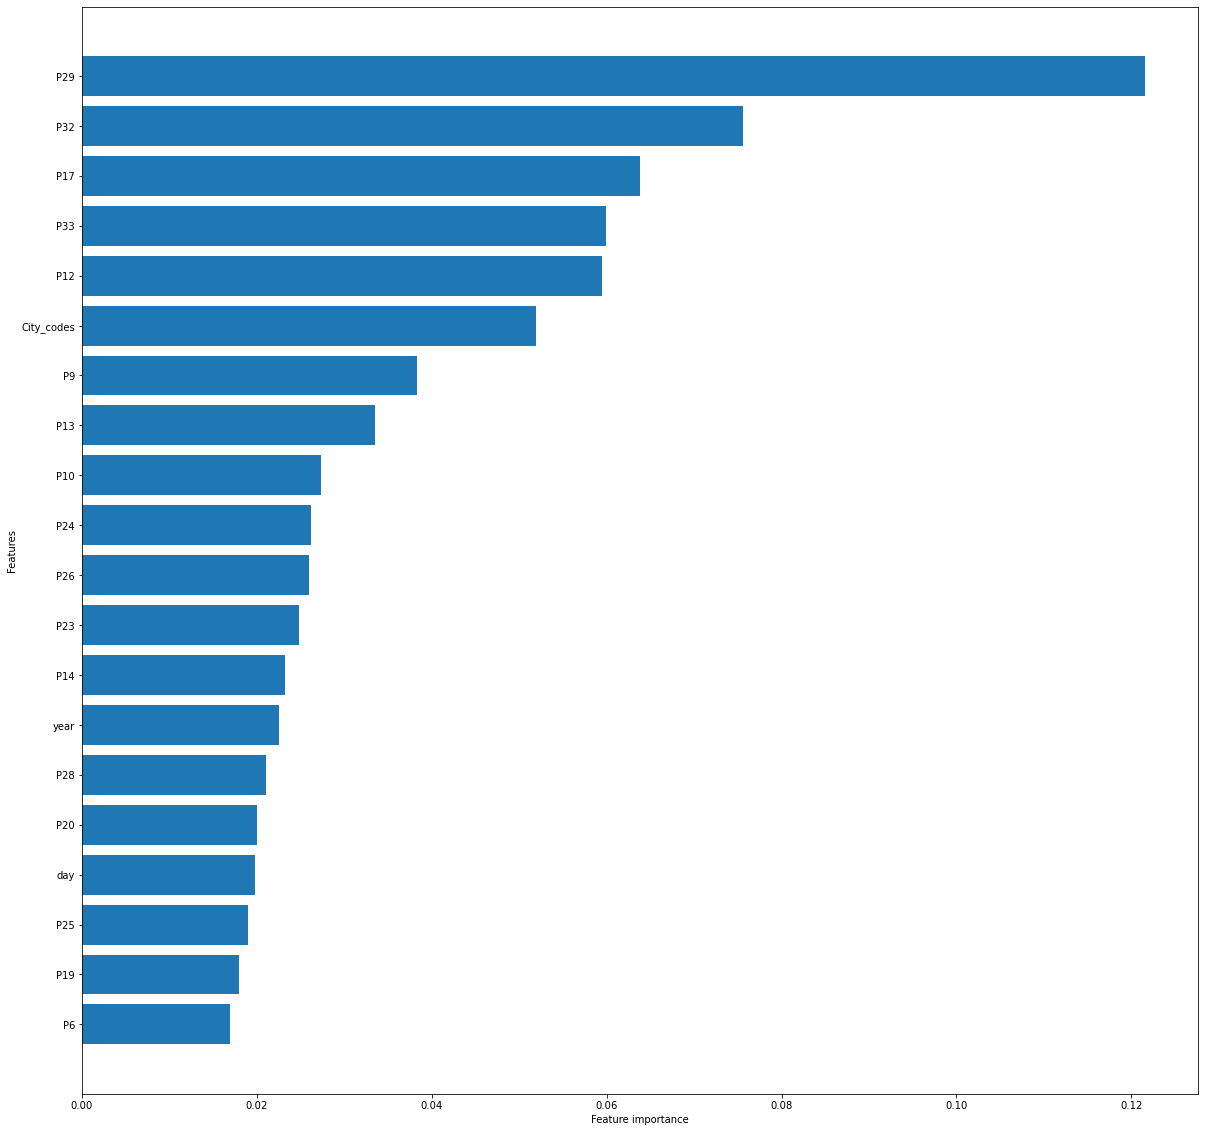

In [51]:
# Importance of each feature (top 20)
plot_features(X_train.columns, model.feature_importances_)